In [69]:
import numpy as np
import control as ctrl
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [70]:
Ts = 0.01

A = np.array([[1]])
B = np.array([[1]])
C = np.array([[1]])
D = np.array([0])

sys_c = ctrl.ss(A, B, C, D)
sys_d = ctrl.c2d(sys_c, Ts, method='zoh')
Ad = sys_d.A
Bd = sys_d.B
Cd = sys_d.C
Dd = sys_d.D

print("Discrete-time system matrices:")
print("Ad:", Ad)
print("Bd:", Bd)
print("Cd:", Cd)
print("Dd:", Dd)

Discrete-time system matrices:
Ad: [[1.01005017]]
Bd: [[0.01005017]]
Cd: [[1.]]
Dd: [[0.]]


##### *Simulation parameters*

In [71]:
# Simulation type: int32 transmission between agents or float
int32_tx = False
scale_factor = 1000 if int32_tx else 1.0

# Simulation parameters: 
dt       = 0.01                         # sampling time
sim_time = 8.0                          # total simulation time 
time     = np.arange(0, sim_time, dt)   # time vector
n_points = len(time)                    # number of time points
n_agents = 9                            # number of agents

# Adaptive gain parameters: 
eta               = 0.5                     # adaptation gain
add_disturbance   = True                    # add disturbance to system
small_error_timer = np.zeros(n_agents)      # timer to stop gain evolution
freeze_threshold  = 0.01                    # error-threshold to freeze gain evolution ("δ" or "ε" in paper)
freeze_time       = 1.0                     # time to freeze gain evolution after threshold is reached   
freeze_steps      = int(freeze_time / dt)   # time steps to freeze gain evolution after threshold is reached

# Distrbance: bounded unknown input 
nu = 0.5 * (np.random.rand(n_agents, n_points) - 0.5)  # uniformly distributed between -0.25 and 0.25

# Sim-params dictionary: 
params = {
    "dt": dt,
    "n_points": n_points,
    "delta": freeze_threshold,
    "small_error_timer": small_error_timer,
    "freeze_steps": freeze_steps,
    "add_disturbance": add_disturbance,
}

# Plotting parameters & function: 
NUM_SIM = 1
SAVE_FIGS = False
FIG_FORMAT = 'pdf'  # 'png', 'pdf', 'svg', etc.

def plot_simulation_grid(t, x, z, vartheta, mv, n_agents, save_path=None):
    """
    Plot x, z, vartheta, and u in a 2x2 grid.
    
    Parameters:
    - t: time vector
    - x, z, vartheta, mv: 2D arrays of shape (n_agents, n_points)
    - n_agents: number of agents
    - save_path: path to save figure (optional)
    - NUM_SIM: simulation number for filename if saving
    """
    # Trim last time step (if necessary)
    t = t[:-1]
    x = x[:,:-1]
    z = z[:,:-1]
    vartheta = vartheta[:,:-1]
    mv = mv[:,:-1]

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    
    # --- Top-left: x_i ---
    for i in range(n_agents):
        axs[0,0].plot(t, x[i,:], label=f'$x_{i+1}$')
    axs[0,0].plot(t, z[0,:], 'k--', label='$z_{1}$ (ref.)')  # Reference trajectory
    axs[0,0].set_title('States $x_i$')
    axs[0,0].set_xlabel('Time [s]')
    axs[0,0].set_ylabel('State')
    axs[0,0].legend(ncol=3)
    axs[0,0].grid(True)
    
    # --- Top-right: z_i ---
    for i in range(n_agents):
        axs[0,1].plot(t, z[i,:], label=f'$z_{i+1}$')
    axs[0,1].set_title('Virtual states $z_i$')
    axs[0,1].set_xlabel('Time [s]')
    axs[0,1].set_ylabel('State')
    axs[0,1].legend(ncol=3)
    axs[0,1].grid(True)
    
    # --- Bottom-left: vartheta_i ---
    for i in range(n_agents):
        axs[1,0].plot(t, vartheta[i,:], label=f'$\\vartheta_{i+1}$')
    axs[1,0].set_title('Adaptive gains $\\vartheta_i$')
    axs[1,0].set_xlabel('Time [s]')
    axs[1,0].set_ylabel('$\\vartheta$')
    axs[1,0].legend(ncol=3)
    axs[1,0].grid(True)
    
    # --- Bottom-right: control u (example: first agent) ---
    axs[1,1].plot(t, mv[0,:], label='$u_1$')
    axs[1,1].set_title('Control input $u_1$')
    axs[1,1].set_xlabel('Time [s]')
    axs[1,1].set_ylabel('$u(t)$')
    axs[1,1].legend()
    axs[1,1].grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        print(f"Figure saved to {save_path}")
    plt.show()

##### *Nodes and graph definirtion*
- $N=9$ agents 
- $N$-node ring directed: 
 
`... → v9 → v1 → v2 → v3 → v4 → v5 → v6 → v7 → v8 → v9 → v1 → ...`

- ***For now*, use the same initial condition for both state $x$ and virtual state $z$**

In [72]:
np.random.seed(42)

# Initial conditions: for states "x" and virtual states "z"

if int32_tx:
    state1_x0 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
    state2_x0 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
    state3_x0 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
    state4_x0 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
    state5_x0 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
    state6_x0 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
    state7_x0 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
    state8_x0 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
    state9_x0 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)

    state1_z0 = np.copy(state1_x0)#np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
    state2_z0 = np.copy(state2_x0)#np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
    state3_z0 = np.copy(state3_x0)#np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
    state4_z0 = np.copy(state4_x0)#np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
    state5_z0 = np.copy(state5_x0)#np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
    state6_z0 = np.copy(state6_x0)#np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
    state7_z0 = np.copy(state7_x0)#np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
    state8_z0 = np.copy(state8_x0)#np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
    state9_z0 = np.copy(state9_x0)#np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)

else:
    state1_x0 = np.random.uniform(-2.0, 2.0)
    state2_x0 = np.random.uniform(-2.0, 2.0)
    state3_x0 = np.random.uniform(-2.0, 2.0)
    state4_x0 = np.random.uniform(-2.0, 2.0)
    state5_x0 = np.random.uniform(-2.0, 2.0)
    state6_x0 = np.random.uniform(-2.0, 2.0)
    state7_x0 = np.random.uniform(-2.0, 2.0)
    state8_x0 = np.random.uniform(-2.0, 2.0)
    state9_x0 = np.random.uniform(-2.0, 2.0)

    state1_z0 = np.copy(state1_x0)#np.random.uniform(-2.0, 2.0)
    state2_z0 = np.copy(state2_x0)#np.random.uniform(-2.0, 2.0)
    state3_z0 = np.copy(state3_x0)#np.random.uniform(-2.0, 2.0)
    state4_z0 = np.copy(state4_x0)#np.random.uniform(-2.0, 2.0)
    state5_z0 = np.copy(state5_x0)#np.random.uniform(-2.0, 2.0)
    state6_z0 = np.copy(state6_x0)#np.random.uniform(-2.0, 2.0)
    state7_z0 = np.copy(state7_x0)#np.random.uniform(-2.0, 2.0)
    state8_z0 = np.copy(state8_x0)#np.random.uniform(-2.0, 2.0)
    state9_z0 = np.copy(state9_x0)#np.random.uniform(-2.0, 2.0)

`... → v9 (Bridge) → v1 (BLE) → v4 (BLE) → v7 (BLE) → v3 (Bridge) → v8 (WiFi) → v6 (WiFi) → v2 (WiFi) → v5 (Bridge) → v9 (Bridge) → v1 (BLE) → ...`

In [73]:
NODES = {
    0: {'x0': state1_x0, 'z0': state1_z0, 'neighbors': [3], 'type': 'BLE'},
    1: {'x0': state2_x0, 'z0': state2_z0, 'neighbors': [4], 'type': 'WiFi'},
    2: {'x0': state3_x0, 'z0': state3_z0, 'neighbors': [7], 'type': 'Bridge'},
    3: {'x0': state4_x0, 'z0': state4_z0, 'neighbors': [6], 'type': 'BLE'},
    4: {'x0': state5_x0, 'z0': state5_z0, 'neighbors': [8], 'type': 'WiFi'},
    5: {'x0': state6_x0, 'z0': state6_z0, 'neighbors': [1], 'type': 'Bridge'},
    6: {'x0': state7_x0, 'z0': state7_z0, 'neighbors': [2], 'type': 'BLE'},
    7: {'x0': state8_x0, 'z0': state8_z0, 'neighbors': [5], 'type': 'WiFi'},
    8: {'x0': state9_x0, 'z0': state9_z0, 'neighbors': [0], 'type': 'Bridge'},
}

# Consensus laws (Dynamics): --------------------------------------------------

# Graph: Laplacian matrix for the directed ring 9-node network
L = np.zeros((n_agents, n_agents))
for i in range(n_agents):
    L[i, i] = 1
    L[i, (i + 1) % n_agents] = -1
    L[i, (i - 1) % n_agents] = -1

# Virtual state dynamics (z): z_i_dot = g(z_i, v_i) = v_i
def v_i(i, z, neighbors):
    diffs = z[i] - z[neighbors]         
    return -np.sum(np.sign(diffs) * np.sqrt(np.abs(diffs)))

def g_i(i, z, neighbors, avg=False):
    if avg:
        if not neighbors:
            return 0.0
        return sum(z[j] - z[i] for j in neighbors)
    else:
        vi = v_i(i, z, neighbors)
        return vi
    
# Initial conditions for states and virtual states: ---------------------------
init_conditions = {
    "x": np.array([NODES[i]['x0'] for i in range(n_agents)]),
    "z": np.array([NODES[i]['z0'] for i in range(n_agents)]),
    "vtheta": np.zeros(n_agents)  # Initial adaptive gains
}

### *State dynamics*
**4th Order Runge-Kutta Method**

In [74]:
def rk4_step(f, t, y, dt, *args):
    """
    One step of fixed-step RK4 integration.

    f : function(t, y, *args) -> dydt
    t : current time
    y : current state vector
    dt: time step
    *args: extra arguments passed to f
    """
    k1 = f(t, y, *args)
    k2 = f(t + dt/2, y + dt/2 * k1, *args)
    k3 = f(t + dt/2, y + dt/2 * k2, *args)
    k4 = f(t + dt,   y + dt   * k3, *args)
    return y + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)

def dynamics(t, y, nodes, n_agents, nu, eta, mv, params):
    x = y[:n_agents]
    z = y[n_agents:2*n_agents]
    vtheta = y[2*n_agents:3*n_agents]

    dydt = np.zeros_like(y)

    for i in range(n_agents):
        neighbors = nodes[i]['neighbors']
        gi = g_i(i, z, neighbors)       # consensus-like term
        z_dot = gi

        sigma = x[i] - z[i]
        grad = np.sign(sigma)

        # Adaptation law
        if np.abs(sigma) > params["delta"]:
            params["small_error_timer"][i] = 0
            vtheta_dot = eta * 1.0
        else:
            params["small_error_timer"][i] += 1
            if params["small_error_timer"][i] < params["freeze_steps"]:
                vtheta_dot = eta * 1.0
            else:
                vtheta_dot = 0.0

        u = gi - vtheta[i] * grad
        x_dot = u 
        x_dot += nu[i] if params["add_disturbance"] else 0

        # Store manipulated variable
        k = int(t / params["dt"])
        if k < params["n_points"]:
            mv[i, k] = u

        dydt[i] = x_dot
        dydt[n_agents + i] = z_dot
        dydt[2*n_agents + i] = vtheta_dot

    return dydt

### *Simulation Loop*

In [75]:
# Preallocate variables: states, manipulated variables and derivatives
x = np.zeros(shape=(n_agents, n_points))
z = np.zeros(shape=(n_agents, n_points))
vtheta = np.zeros(shape=(n_agents, n_points))
mv = np.zeros(shape=(n_agents, n_points))
y = np.concatenate(
    [init_conditions["x"], init_conditions["z"], init_conditions["vtheta"]]
)

t = 0.0
for k in range(n_points):

    x[:, k] = y[:n_agents]
    z[:, k] = y[n_agents:2*n_agents]
    vtheta[:, k] = y[2*n_agents:3*n_agents]
    y = rk4_step(dynamics, t, y, dt, NODES, n_agents, nu[:, k], eta, mv, params)

    # Logging for agent 1
    if k % 50 == 0:  
        print(f"Agent 1: t={t:.2f}, x1={x[0,k]:.4f}, z1={z[0,k]:.4f}, vtheta1={vtheta[0,k]:.4f}, u1={mv[0,k]:.4f}")
    
    t += dt

Agent 1: t=0.00, x1=-0.5018, z1=-0.5018, vtheta1=0.0000, u1=0.9379
Agent 1: t=0.50, x1=-0.2085, z1=-0.2091, vtheta1=0.1242, u1=-0.0634
Agent 1: t=1.00, x1=-0.3519, z1=-0.3531, vtheta1=0.1242, u1=-0.4093
Agent 1: t=1.50, x1=-0.3156, z1=-0.3143, vtheta1=0.1242, u1=0.4215
Agent 1: t=2.00, x1=-0.1360, z1=-0.1364, vtheta1=0.1242, u1=0.2665
Agent 1: t=2.50, x1=0.0383, z1=0.0378, vtheta1=0.1242, u1=0.3454
Agent 1: t=3.00, x1=0.0172, z1=0.0165, vtheta1=0.1242, u1=-0.0575
Agent 1: t=3.50, x1=-0.0710, z1=-0.0726, vtheta1=0.1242, u1=-0.2060
Agent 1: t=4.00, x1=-0.0438, z1=-0.0426, vtheta1=0.1242, u1=0.1435
Agent 1: t=4.50, x1=-0.0489, z1=-0.0488, vtheta1=0.1242, u1=-0.1361
Agent 1: t=5.00, x1=-0.0485, z1=-0.0487, vtheta1=0.1242, u1=-0.1123
Agent 1: t=5.50, x1=-0.0497, z1=-0.0487, vtheta1=0.1242, u1=-0.1364
Agent 1: t=6.00, x1=-0.0490, z1=-0.0488, vtheta1=0.1242, u1=-0.1120
Agent 1: t=6.50, x1=-0.0487, z1=-0.0487, vtheta1=0.1242, u1=0.1121
Agent 1: t=7.00, x1=-0.0492, z1=-0.0488, vtheta1=0.1242, u

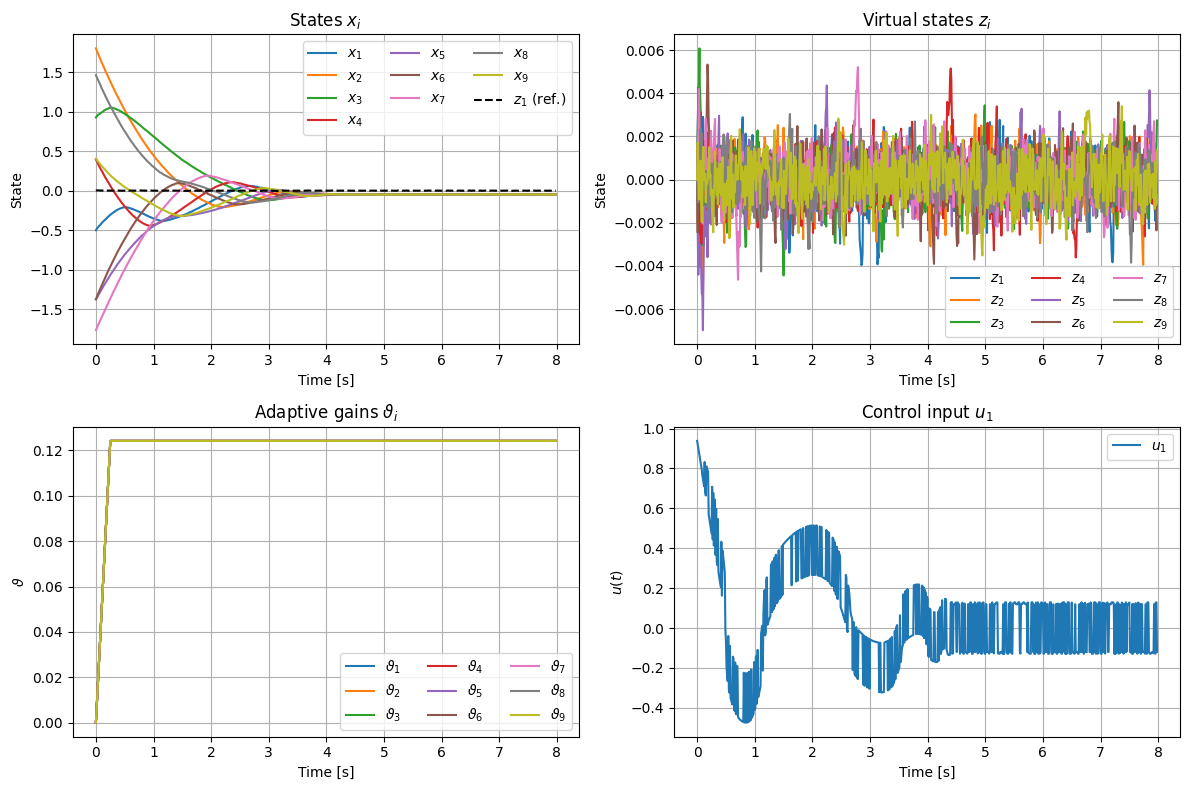

In [76]:
t_vec = np.linspace(0, dt*(n_points-1), n_points)
save_file = f'img/python-sim/simulation_{NUM_SIM}.pdf' if SAVE_FIGS else None
plot_simulation_grid(t_vec, x, x-z, vtheta, mv, n_agents, save_path=save_file)

---

### *State dynamics*
**4th Order Runge-Kutta Method:** using $\verb|solve_ivp(.)|$ solver

In [77]:
# Preallocate variables: states, manipulated variables and derivatives
x = np.zeros(shape=(n_agents, n_points))
z = np.zeros(shape=(n_agents, n_points))
vtheta = np.zeros(shape=(n_agents, n_points))
mv = np.zeros(shape=(n_agents, n_points))
y = np.concatenate(
    [init_conditions["x"], init_conditions["z"], init_conditions["vtheta"]]
)

t = 0.0
for k in range(n_points-1): 

    x[:, k] = y[:n_agents]
    z[:, k] = y[n_agents:2*n_agents]
    vtheta[:, k] = y[2*n_agents:3*n_agents]

    # Update for next iteration
    t_span = (t, t + dt)
    t_eval = (t, t + dt)
    sol = solve_ivp(
        dynamics, t_span, y, 
        t_eval=t_eval,
        args=(NODES, n_agents, nu[:, k], eta, mv, params)
    )
    y = sol.y[:, -1]  

    # Logging for agent 1
    if k % 50 == 0:
        print(f"Agent 1: t={t:.2f}, x1={x[0,k]:.4f}, z1={z[0,k]:.4f}, vtheta1={vtheta[0,k]:.4f}, u1={mv[0,k]:.4f}")

    t += dt

Agent 1: t=0.00, x1=-0.5018, z1=-0.5018, vtheta1=0.0000, u1=0.9355
Agent 1: t=0.50, x1=-0.2036, z1=-0.2091, vtheta1=0.0795, u1=-0.0916
Agent 1: t=1.00, x1=-0.3515, z1=-0.3531, vtheta1=0.2986, u1=0.0214
Agent 1: t=1.50, x1=-0.3144, z1=-0.3143, vtheta1=0.5486, u1=-0.2543
Agent 1: t=2.00, x1=-0.1358, z1=-0.1364, vtheta1=0.7906, u1=-0.4048
Agent 1: t=2.50, x1=0.0379, z1=0.0378, vtheta1=1.0322, u1=-0.8159
Agent 1: t=3.00, x1=0.0165, z1=0.0165, vtheta1=1.2538, u1=1.0772
Agent 1: t=3.50, x1=-0.0721, z1=-0.0726, vtheta1=1.4143, u1=-1.5012
Agent 1: t=4.00, x1=-0.0428, z1=-0.0426, vtheta1=1.6643, u1=1.6886
Agent 1: t=4.50, x1=-0.0487, z1=-0.0488, vtheta1=1.9143, u1=-1.9197
Agent 1: t=5.00, x1=-0.0488, z1=-0.0488, vtheta1=2.1643, u1=-2.1692
Agent 1: t=5.50, x1=-0.0489, z1=-0.0488, vtheta1=2.4139, u1=-2.4188
Agent 1: t=6.00, x1=-0.0487, z1=-0.0488, vtheta1=2.6636, u1=2.6688
Agent 1: t=6.50, x1=-0.0488, z1=-0.0488, vtheta1=2.9126, u1=2.9174
Agent 1: t=7.00, x1=-0.0488, z1=-0.0488, vtheta1=3.1620, u

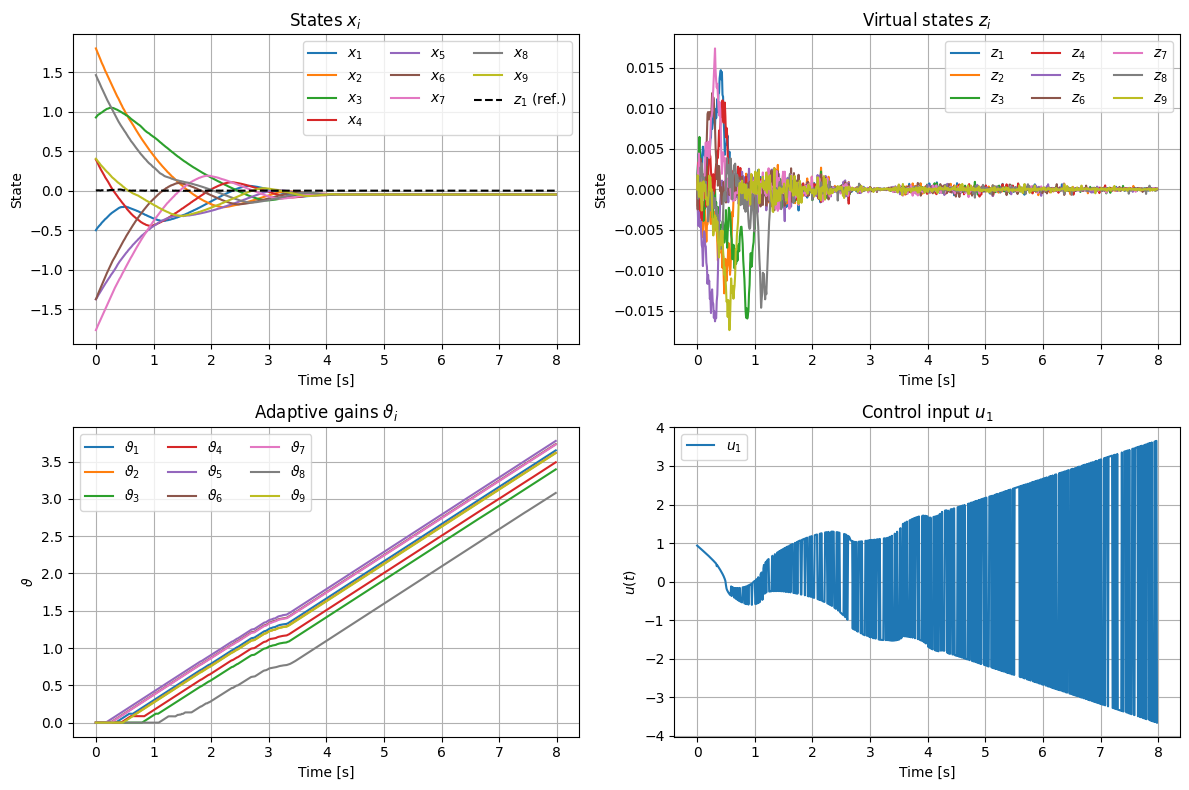

In [78]:
t_vec = np.linspace(0, dt*(n_points-1), n_points)
save_file = f'img/python-sim/simulation_ivp_{NUM_SIM}.pdf' if SAVE_FIGS else None
plot_simulation_grid(t_vec, x, x-z, vtheta, mv, n_agents, save_path=save_file)

---

### **Euler Method**

**Laplacian for a 9-node ring network**
$$v = -\mathbf{L} z$$
$$g(z,v) = v$$
$$\dot{z} = g(z,v)$$

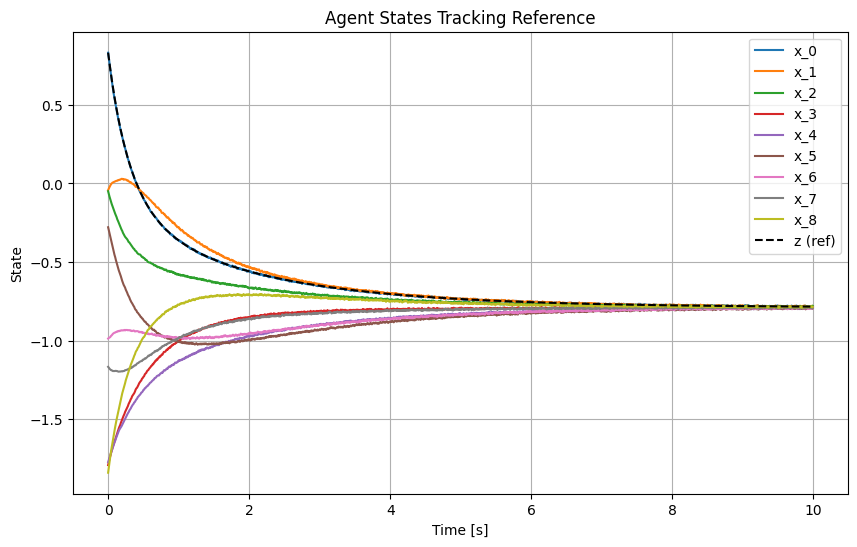

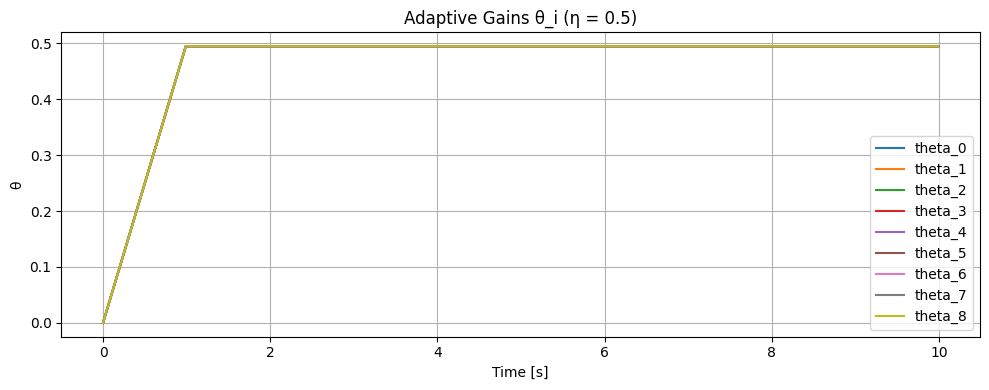

In [79]:
# Simulation parameters
T = 10.0
dt = 0.01
time = np.arange(0, T, dt)
n_agents = len(NODES) 

# Adaptive gain parameters
eta = 0.5  
small_error_timer = np.zeros(n_agents)
freeze_threshold = 0.01  # error threshold
freeze_time = 1.0        # seconds of small error before freezing
freeze_steps = int(freeze_time / dt)

# Graph (Laplacian for a ring network)
L = np.zeros((n_agents, n_agents))
for i in range(n_agents):
    L[i, i] = 2
    L[i, (i + 1) % n_agents] = -1
    L[i, (i - 1) % n_agents] = -1

# Initialization
x = np.random.uniform(-2, 2, (n_agents, len(time)))  # states
z = np.copy(x)                                       # reference
theta = np.zeros((n_agents, len(time)))              # adaptive gain
sigma = np.zeros((n_agents, len(time)))              # tracking error

# Disturbance
nu = 0.5 * (np.random.rand(n_agents, len(time)) - 0.5)  # bounded unknown input

# Adaptive control simulation
theta_max = 10.0
for k in range(len(time) - 1):
    # Reference dynamics
    v = -L @ z[:, k]
    g = v  # Assuming g_i(z_i, v_i) = v_i
    z[:, k + 1] = z[:, k] + dt * g

for k in range(len(time) - 1):
    # Reference dynamics
    v = -L @ z[:, k]
    g = v
    z[:, k + 1] = z[:, k] + dt * g

    # Compute sigma and gradient
    sigma[:, k] = x[:, k] - z[:, k]
    grad = np.sign(sigma[:, k])

    # Update adaptive gain theta with new eta parameter
    dtheta = np.zeros(n_agents)
    for i in range(n_agents):
        if np.abs(sigma[i, k]) > freeze_threshold:
            small_error_timer[i] = 0  # reset timer
            dtheta[i] = eta * 1.0  # NEW: multiplied by eta
        else:
            small_error_timer[i] += 1
            if small_error_timer[i] < freeze_steps:
                dtheta[i] = eta * 1.0  # NEW: multiplied by eta
            else:
                dtheta[i] = 0.0  # freeze gain

    theta[:, k + 1] = theta[:, k] + dt * dtheta
    theta[:, k + 1] = np.clip(theta[:, k + 1], 0, theta_max)

    # Control input
    u = g - theta[:, k] * grad
    x[:, k + 1] = x[:, k] + dt * (u + nu[:, k])

# Plotting results
plt.figure(figsize=(10, 6))
for i in range(n_agents):
    plt.plot(time, x[i], label=f"x_{i}")
plt.plot(time, z[0], 'k--', label="z (ref)")
plt.title("Agent States Tracking Reference")
plt.xlabel("Time [s]")
plt.ylabel("State")
plt.legend()
plt.grid()

plt.figure(figsize=(10, 4))
for i in range(n_agents):
    plt.plot(time, theta[i], label=f"theta_{i}")
plt.title("Adaptive Gains θ_i (η = {})".format(eta))  
plt.xlabel("Time [s]")
plt.ylabel("θ")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

$$\dot{z}_i = v_i = -\sum_{j\neq i}\text{sign}(z_i-z_j)|z_i-z_j|^{0.5}$$

Error for agent 0: 0.0, neighbors: [3], g: 0.18165902124584926
Error for agent 0: 0.0010000000000000009, neighbors: [3], g: 0.15811388300841903
Error for agent 0: -0.0010000000000000009, neighbors: [3], g: 0.13038404810405302
Error for agent 0: -0.0020000000000000018, neighbors: [3], g: 0.10000000000000005
Error for agent 0: -0.0020000000000000018, neighbors: [3], g: 0.06324555320336761
Error for agent 0: -0.0020000000000000018, neighbors: [3], g: -0.044721359549995815
Error for agent 0: 0.0, neighbors: [3], g: -0.08366600265340693
Error for agent 0: 0.0, neighbors: [3], g: -0.10488088481701467
Error for agent 0: 0.0010000000000000009, neighbors: [3], g: -0.12247448713915851
Error for agent 0: 0.0030000000000000027, neighbors: [3], g: -0.13416407864998703
Error for agent 0: 0.0010000000000000009, neighbors: [3], g: -0.14491376746189408
Error for agent 0: 0.0020000000000000018, neighbors: [3], g: -0.1549193338482964
Error for agent 0: 0.0019999999999998908, neighbors: [3], g: -0.1612451

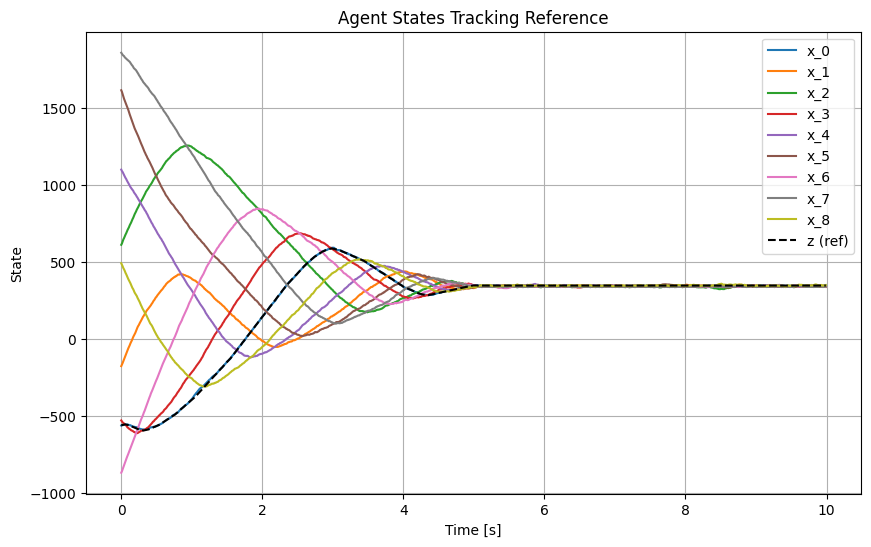

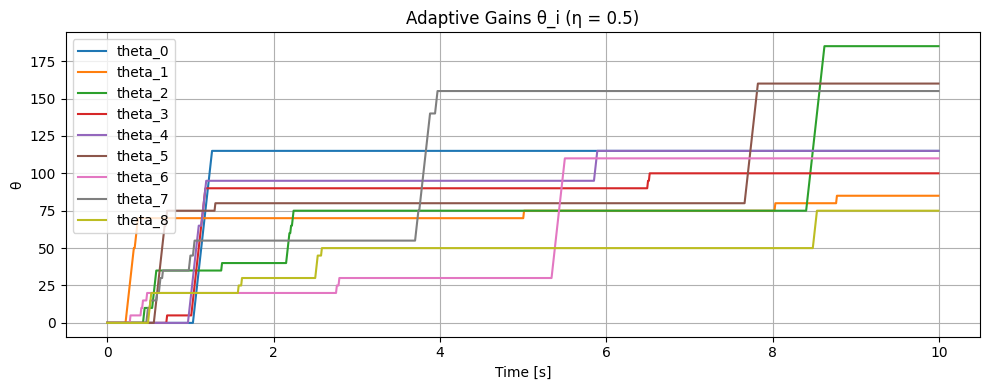

In [80]:
# Simulation parameters
T = 10.0
dt = 0.01
time = np.arange(0, T, dt)
n_agents = len(NODES) 

# Adaptive gain parameters
eta = 0.5  
small_error_timer = np.zeros(n_agents)
freeze_threshold = 0.01  # error threshold
freeze_time = 1.0        # seconds of small error before freezing
freeze_steps = int(freeze_time / dt)

# Initialization
x = np.random.uniform(-2, 2, (n_agents, len(time)))  # states
z = np.copy(x)                                           # reference
v = np.zeros((n_agents,))                                # reference dynamics
vtheta = np.zeros((n_agents, len(time)))                  # adaptive gain
sigma = np.zeros((n_agents, len(time)))                  # tracking error

# Disturbance
nu = 0.5 * (np.random.rand(n_agents, len(time)) - 0.5)  # bounded unknown input

# Initial floating-point values
x_f = np.random.uniform(-2, 2, n_agents)
z_f = np.copy(x_f)
vtheta_f = np.zeros(n_agents)

# Store initial values as int32
scale_factor = 1000  # scaling to preserve decimal precision when storing as int
x[:, 0] = np.round(x_f * scale_factor).astype(np.int32)
z[:, 0] = np.round(z_f * scale_factor).astype(np.int32)
vtheta[:, 0] = np.round(vtheta_f * scale_factor).astype(np.int32)

theta_max = 10.0
for k in range(len(time) - 1):

    z_f = z[:, k] / scale_factor  
    x_f = x[:, k] / scale_factor
    vtheta_f = vtheta[:, k] / scale_factor

    # Reference dynamics
    for i in range(n_agents):
        neighbors = NODES[i]['neighbors']
        v[i] = g_i(i, z_f, neighbors)

    g = v
    z_f_next = z_f + dt * g

    sigma[:, k] = x_f - z_f

    grad = np.sign(sigma[:, k])

     # Update adaptive gain theta
    dtheta = np.zeros(n_agents)
    for i in range(n_agents):
        if i == 0:
            print(f"Error for agent {i}: {sigma[i, k]}, neighbors: {NODES[i]['neighbors']}, g: {g[i]}")
        if np.abs(sigma[i, k]) > freeze_threshold:
            small_error_timer[i] = 0
            dtheta[i] = eta* 1.0
        else:
            dtheta[i] = 0.0
            # if i == 0: 
            #     print(f"Agent {i} small error timer: {small_error_timer[i]}")

            # small_error_timer[i] += 1
            # if small_error_timer[i] < freeze_steps:
            #     dtheta[i] = eta * 1.0
            # else:
            #     dtheta[i] = 0.0

    vtheta_f_next = vtheta_f + dt * dtheta
    vtheta_f_next = np.clip(vtheta_f_next, 0, theta_max)

    # Control input
    u = g - vtheta_f * grad
    x_f_next = x_f + dt * (u + nu[:, k])

    # Store as int32
    z[:, k + 1] = np.round(z_f_next * scale_factor).astype(np.int32)
    x[:, k + 1] = np.round(x_f_next * scale_factor).astype(np.int32)
    vtheta[:, k + 1] = np.round(vtheta_f_next * scale_factor).astype(np.int32)


# Plotting results
plt.figure(figsize=(10, 6))
for i in range(n_agents):
    plt.plot(time, x[i], label=f"x_{i}")
plt.plot(time, z[0], 'k--', label="z (ref)")
plt.title("Agent States Tracking Reference")
plt.xlabel("Time [s]")
plt.ylabel("State")
plt.legend()
plt.grid()

plt.figure(figsize=(10, 4))
for i in range(n_agents):
    plt.plot(time, vtheta[i], label=f"theta_{i}")
plt.title("Adaptive Gains θ_i (η = {})".format(eta))  
plt.xlabel("Time [s]")
plt.ylabel("θ")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

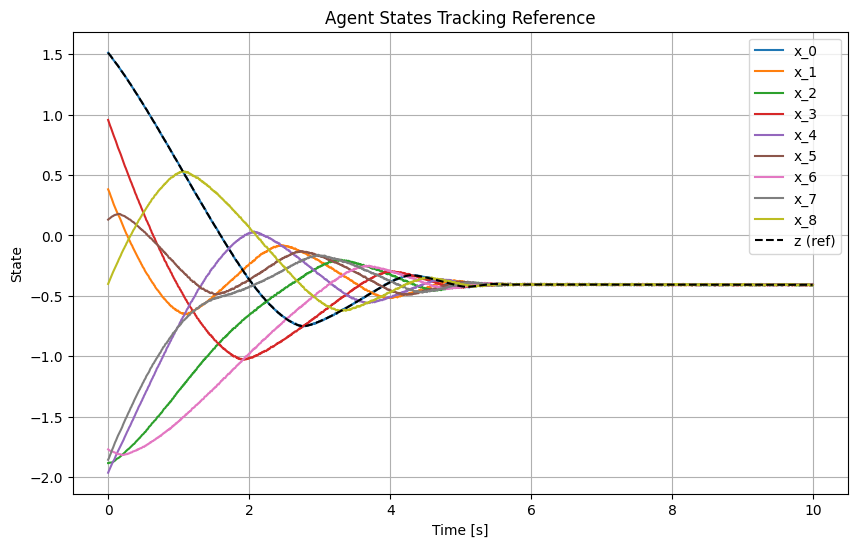

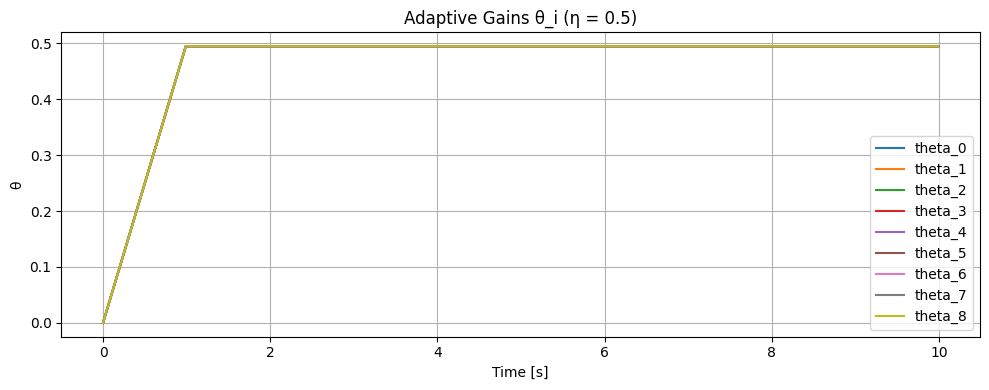

In [81]:
# Simulation parameters
T = 10.0
dt = 0.01
time = np.arange(0, T, dt)
n_agents = len(NODES) 

# Adaptive gain parameters
eta = 0.5  
small_error_timer = np.zeros(n_agents)
freeze_threshold = 0.01  # error threshold
freeze_time = 1.0        # seconds of small error before freezing
freeze_steps = int(freeze_time / dt)

# Initialization
x = np.random.uniform(-2, 2, (n_agents, len(time)))  # states
z = np.copy(x)                                       # reference
theta = np.zeros((n_agents, len(time)))              # adaptive gain
sigma = np.zeros((n_agents, len(time)))              # tracking error

# Disturbance
nu = 0.5 * (np.random.rand(n_agents, len(time)) - 0.5)  # bounded unknown input

# Adaptive control simulation
theta_max = 10.0
for k in range(len(time) - 1):
    # Reference dynamics
        # Reference dynamics
    for i in range(n_agents):
        neighbors = NODES[i]['neighbors']
        v[i] = g_i(i, z[:, k], neighbors)

    g = v
    z[:, k + 1] = z[:, k] + dt * g

    # Compute sigma and gradient
    sigma[:, k] = x[:, k] - z[:, k]
    grad = np.sign(sigma[:, k])

    # Update adaptive gain theta with new eta parameter
    dtheta = np.zeros(n_agents)
    for i in range(n_agents):
        if np.abs(sigma[i, k]) > freeze_threshold:
            small_error_timer[i] = 0  # reset timer
            dtheta[i] = eta * 1.0  # NEW: multiplied by eta
        else:
            small_error_timer[i] += 1
            if small_error_timer[i] < freeze_steps:
                dtheta[i] = eta * 1.0  # NEW: multiplied by eta
            else:
                dtheta[i] = 0.0  # freeze gain

    theta[:, k + 1] = theta[:, k] + dt * dtheta
    theta[:, k + 1] = np.clip(theta[:, k + 1], 0, theta_max)

    # Control input
    u = g - theta[:, k] * grad
    x[:, k + 1] = x[:, k] + dt * (u + nu[:, k])

# Plotting results
plt.figure(figsize=(10, 6))
for i in range(n_agents):
    plt.plot(time, x[i], label=f"x_{i}")
plt.plot(time, z[0], 'k--', label="z (ref)")
plt.title("Agent States Tracking Reference")
plt.xlabel("Time [s]")
plt.ylabel("State")
plt.legend()
plt.grid()

plt.figure(figsize=(10, 4))
for i in range(n_agents):
    plt.plot(time, theta[i], label=f"theta_{i}")
plt.title("Adaptive Gains θ_i (η = {})".format(eta))  
plt.xlabel("Time [s]")
plt.ylabel("θ")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()